# Laboratorio 7 - series de tiempo

### Ricardo Valenzuela
### Diego Solorzano

Cada uno de los conjuntos representan series de tiempo, pero muestran diferentes características relacionadas con la tendencias, estacionalidad, período, etc.

Hemos visto 5 métodos diferentes para predecir con series de tiempo, a decir:
 1. Promedio (para usar como base de referencia)
 2. SARIMAX
 3. Alisamiento exponencial (Winter-Holt)
 4. Red Neuronal
 5. FB Prophet

En este laboratorio, deben ejecutar los 5 métodos para cada uno de los conjuntos de datos.

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statistics import *
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.pyplot import figure

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import fbprophet

In [99]:
def division_entreno_prueba(datos, n_prueba):
    return datos[: -n_prueba], datos[-n_prueba:] 

### Carga de datos

In [100]:
births = pd.read_csv("daily-total-female-births.csv", encoding='latin1')
shampoo = pd.read_csv("shampoo.csv", encoding='latin1')
cars = pd.read_csv("monthly-car-sales.csv", encoding='latin1')
monthly = pd.read_csv("monthly-mean-temp.csv", encoding='latin1')

# Series de tiempo para daily-total-female-births.csv

In [101]:
births.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    365 non-null    object
 1   Births  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [102]:
births.head()

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [103]:
births.index = pd.to_datetime(births['Date'])
births.drop(columns='Date',inplace=True)
births.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [104]:
train, prueba = division_entreno_prueba(births, 100)

In [105]:
train

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-09-18,53
1959-09-19,55
1959-09-20,39


In [9]:
prueba

,Births
Date,
1959-09-23,73
1959-09-24,55
1959-09-25,44
1959-09-26,43
1959-09-27,40
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


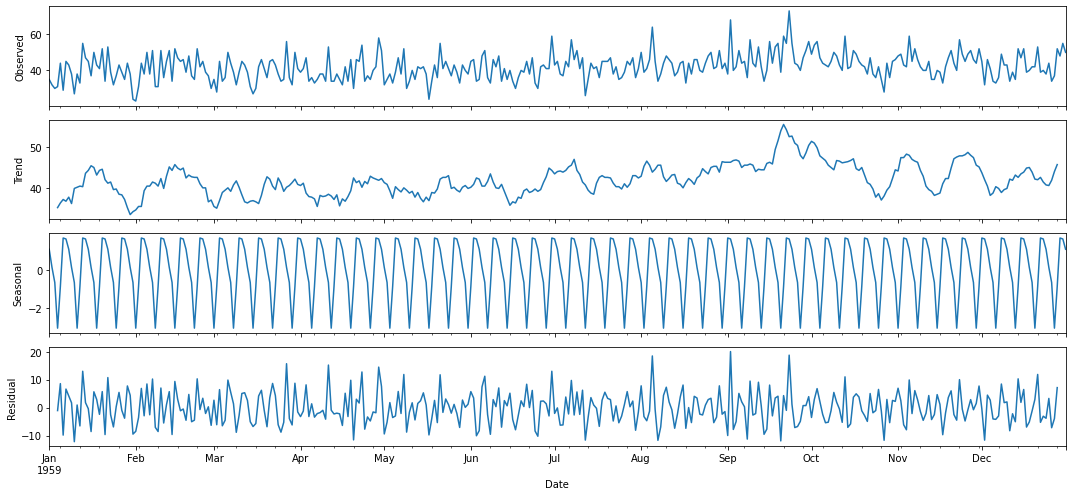

In [106]:
decompose_data = sm.tsa.seasonal_decompose(births, model="additive")
decompose_data.plot();

### Promedio
Obtenida de la presentacion

In [107]:
def prediccion_promedio(historia, config):
    n, tipo_prom = config
    if tipo_prom is "prom":
        return mean(historia[-n:])
    return median(historia[-n:])

In [108]:
print(prediccion_promedio(births['Births'], (265, 'prom')))

42.90188679245283


In [109]:
prueba["error"] = prueba["Births"] - prediccion_promedio(births['Births'], (265, 'prom'))

C:\Users\Zephyrus\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [110]:
print("Error promedio: ", prueba.error.mean())

Error promedio:  1.5081132075471657


### Sarimax

In [111]:
train, prueba = division_entreno_prueba(births, 100)

<AxesSubplot:xlabel='Date'>

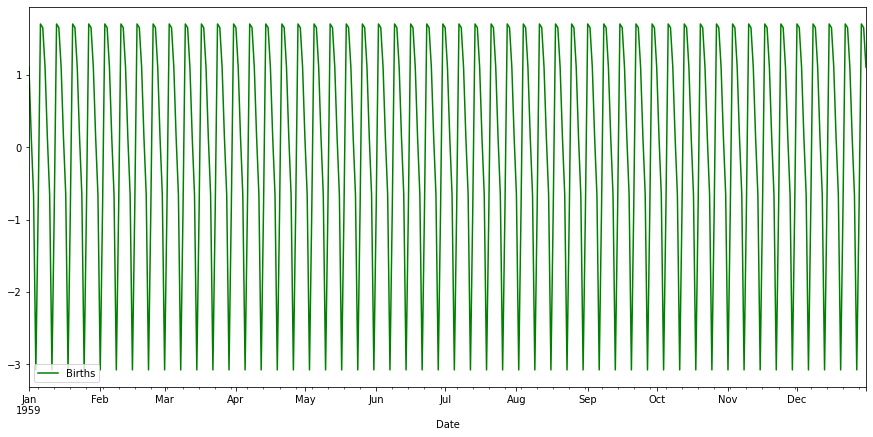

In [112]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

Hacemos esta prueba para ver si la Serie de Tiempo es estacionaria o no, vemos que el valor-p es muy cercano a 0 y menor que 0.05, lo que nos indica que es estacionaria y no hay que hacerle ningun procedimiento extra.

In [113]:
dftest = sm.tsa.stattools.adfuller(births.Births, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.808291253559763
2. P-Value :  5.243412990149865e-05
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 358
5. Critical Values :
	 1% :  -3.448748905151901
	 5% :  -2.8696473721448728
	 10% :  -2.5710891239349585


In [114]:
model=sm.tsa.statespace.SARIMAX(train['Births'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [115]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             Births   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -867.320
Date:                            Mon, 27 Sep 2021   AIC                           1744.640
Time:                                    12:37:51   BIC                           1762.287
Sample:                                01-01-1959   HQIC                          1751.741
                                     - 09-22-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0400      0.065      0.612      0.540      -0.088       0.168
ma.L1         -0.9669      0.030    -32.710      0.000      -1.025      -0.909
ar.S.L12      -0.1743      0.069     -2.514      0.012      -0.310      -0.038
ma.S.L12      -0.8919      0.072    -12.402      0.000      -1.033      -0.751
sigma2        51.2462      4.528     11.317      0.000      42.371      60.121
===================================================================================
Ljung-Box (Q):                       29.29   Jarque-Bera (JB):                 9.39
Prob(Q):                              0.89   Prob(JB):                         0.01
Heteroskedasticity (H):               0.88   Skew:                             0.16
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Vemos graficamente la prediccion.

C:\Users\Zephyrus\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:xlabel='Date'>

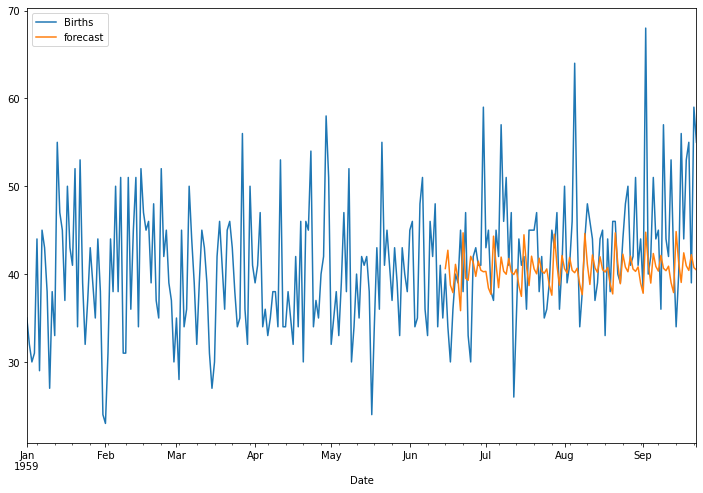

In [116]:
train['forecast']=results.predict(start=165,end=265,dynamic=True)
train[['Births','forecast']].plot(figsize=(12,8))

In [117]:
pred = results.predict(0, 100, dinamic= True, exog = prueba)[1:]
print("MSE: ",(mean_squared_error(prueba, pred)))
print("RMSE: ", sqrt(mean_squared_error(prueba, pred)))

MSE:  96.99609551482438
RMSE:  9.84865957959886


C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1935: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


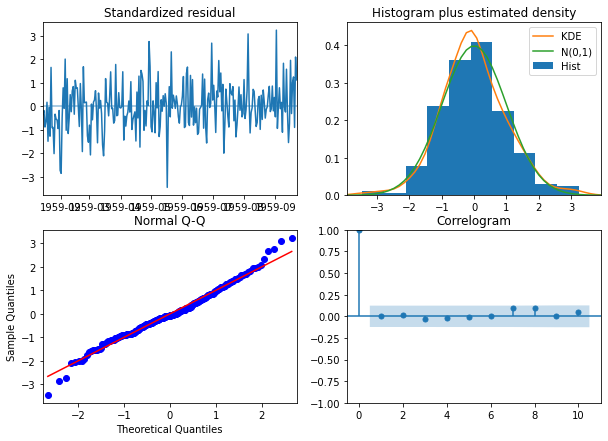

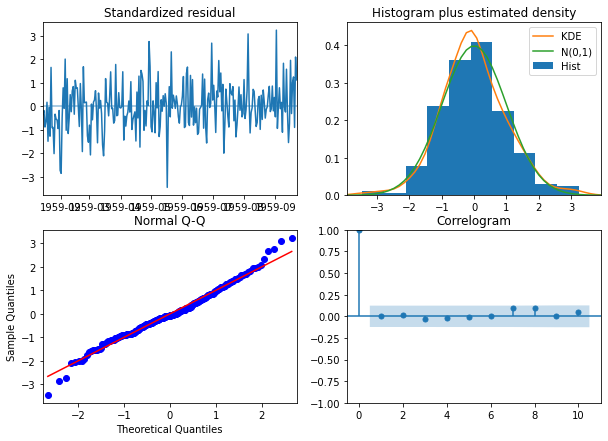

In [118]:
results.plot_diagnostics(figsize=(10, 7))

### Winter Holt

In [119]:
births2 = births

In [120]:
plt.rcParams['figure.figsize'] = [15, 7]

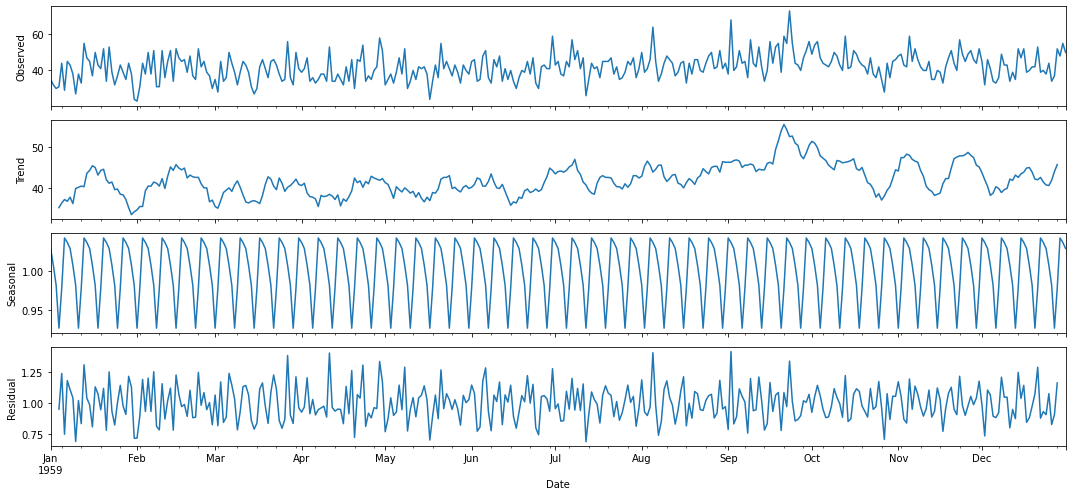

In [121]:
decompose_result = sm.tsa.seasonal_decompose(births2['Births'],model='multiplicative')
decompose_result.plot();

In [122]:
births.index.Births = 'MS'
m = 12
alpha = 1/(2*m)

C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


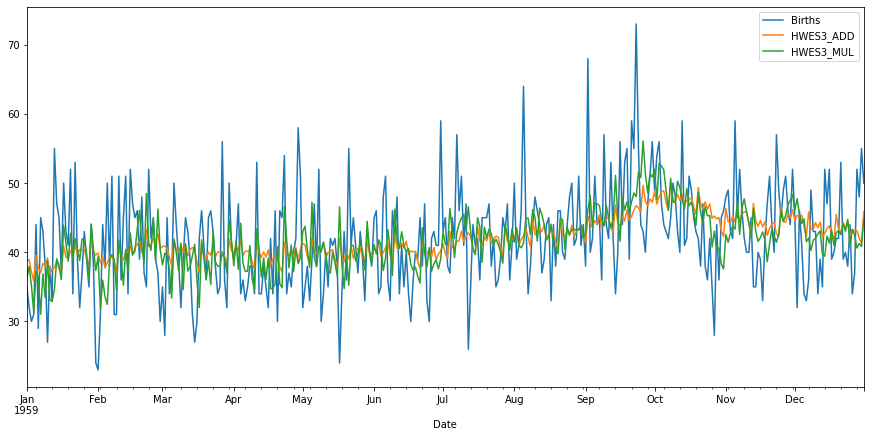

In [123]:
# Se usa triple HWES
births2['HWES3_ADD'] = ExponentialSmoothing(births2['Births'],trend='add', seasonal='add',seasonal_periods=12).fit().fittedvalues
births2['HWES3_MUL'] = ExponentialSmoothing(births2['Births'],trend='mul', seasonal='mul',seasonal_periods=12).fit().fittedvalues
births2[['Births','HWES3_ADD','HWES3_MUL']].plot();

In [124]:
train, prueba = division_entreno_prueba(births2, 150)

C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

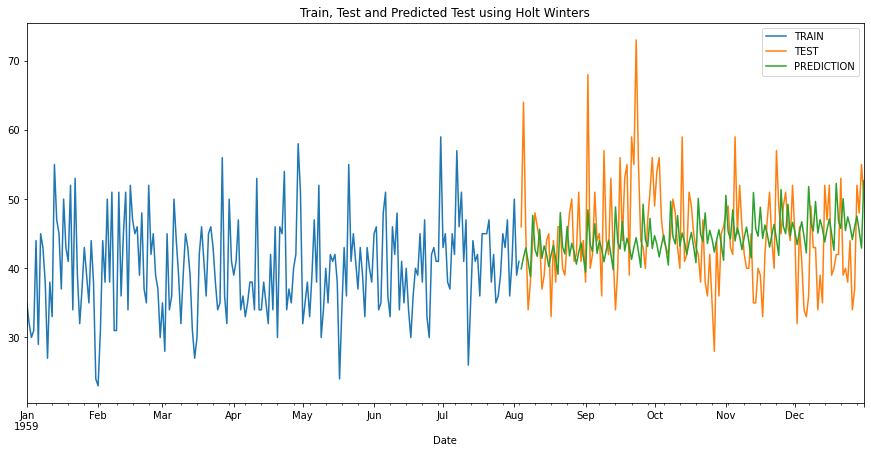

In [125]:
fitted_model = ExponentialSmoothing(train['Births'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(150)
train['Births'].plot(legend=True, label='TRAIN')
prueba['Births'].plot(legend=True, label='TEST', figsize=(15,7))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [126]:
print("MSE: ", mean_squared_error(prueba.Births,test_predictions))
print("RMSE: ",sqrt(mean_squared_error(prueba.Births,test_predictions)))

MSE:  60.751628198726564
RMSE:  7.794333082357115


### Redes Neuronales

In [127]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [128]:
np.random.seed(7)

In [129]:
births = pd.read_csv("daily-total-female-births.csv", encoding='latin1')

In [130]:
births.index = pd.to_datetime(births['Date'])
births.drop(columns='Date',inplace=True)
births.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [131]:
train, prueba = division_entreno_prueba(births2, 150)

In [132]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)
prueba = sc.fit_transform(prueba)

In [133]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(prueba, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [134]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
211/211 - 1s - loss: 0.0768
Epoch 2/50
211/211 - 0s - loss: 0.0373
Epoch 3/50
211/211 - 0s - loss: 0.0373
Epoch 4/50
211/211 - 0s - loss: 0.0375
Epoch 5/50
211/211 - 0s - loss: 0.0375
Epoch 6/50
211/211 - 0s - loss: 0.0375
Epoch 7/50
211/211 - 0s - loss: 0.0375
Epoch 8/50
211/211 - 0s - loss: 0.0371
Epoch 9/50
211/211 - 0s - loss: 0.0367
Epoch 10/50
211/211 - 0s - loss: 0.0374
Epoch 11/50
211/211 - 0s - loss: 0.0374
Epoch 12/50
211/211 - 0s - loss: 0.0372
Epoch 13/50
211/211 - 0s - loss: 0.0371
Epoch 14/50
211/211 - 0s - loss: 0.0373
Epoch 15/50
211/211 - 0s - loss: 0.0370
Epoch 16/50
211/211 - 0s - loss: 0.0373
Epoch 17/50
211/211 - 0s - loss: 0.0371
Epoch 18/50
211/211 - 0s - loss: 0.0372
Epoch 19/50
211/211 - 0s - loss: 0.0368
Epoch 20/50
211/211 - 0s - loss: 0.0359
Epoch 21/50
211/211 - 0s - loss: 0.0370
Epoch 22/50
211/211 - 0s - loss: 0.0371
Epoch 23/50
211/211 - 0s - loss: 0.0370
Epoch 24/50
211/211 - 0s - loss: 0.0371
Epoch 25/50
211/211 - 0s - loss: 0.0370
Epoch 26/

In [135]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Se comprueba el RMSE para el conjunto de prueba

In [136]:
max_value = births.Births.max()

In [137]:
testScore = sqrt(mean_squared_error(testY, testPredict[:,0])*max_value)
print("MSE: ", mean_squared_error(testY, testPredict[:,0])*max_value)
print("RMSE: ", testScore)

MSE:  2.553914111213908
RMSE:  1.598097028097452


### Prophet

In [138]:
from pandas import to_datetime
births = pd.read_csv("daily-total-female-births.csv", encoding='latin1')

In [139]:
births2 = births

In [140]:
print('Prophet %s' % fbprophet.__version__)

Prophet 0.6


In [141]:
births2.columns = ['ds', 'y']
births2['ds']= to_datetime(births2['ds'])

In [142]:
train, prueba = division_entreno_prueba(births2, 150)

In [143]:
model = fbprophet.Prophet()
# fit the model
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prueba haciendo forecast a los datos de prueba

          ds       yhat  yhat_lower  yhat_upper
0 1959-08-01  40.243708   32.191731   48.324573
1 1959-09-01  45.280430   36.826616   53.943476
2 1959-10-01  43.949774   36.092744   52.387909
3 1959-11-01  39.456342   30.998552   47.692842
4 1959-12-01  46.432124   38.476747   54.592716


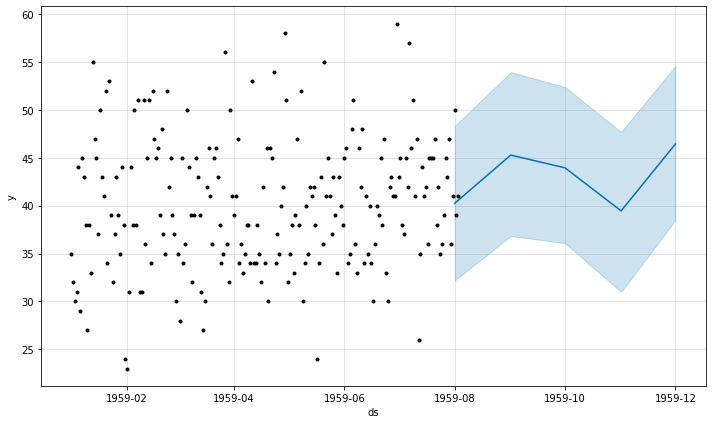

In [144]:
future = list()
for i in range(8, 13):
    date = '1959-%01d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [145]:
births.index = pd.to_datetime(births['ds'])
births.drop(columns='ds',inplace=True)
births.head()

,y
ds,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [146]:
meses = births.resample('M').mean()
meses = meses[-5:]

In [148]:
testScore = sqrt(mean_squared_error(meses, forecast["yhat"]))
print("MSE: ", mean_squared_error(meses, forecast["yhat"]))
print("RMSE: ", testScore)

MSE:  13.357113052696079
RMSE:  3.6547384383422132


# Series de tiempo para shampoo.csv

In [149]:
shampoo = pd.read_csv("shampoo.csv", encoding='latin1')

In [150]:
shampoo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   36 non-null     object 
 1   Sales   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 704.0+ bytes


In [151]:
shampoo.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [152]:
import datetime
shampoo['Month'] = shampoo['Month'].apply(lambda x: datetime.datetime.strptime(x, '%m-%d') if type(x)==str else np.NaN)

In [153]:
shampoo.index = pd.to_datetime(shampoo['Month'])
shampoo.drop(columns='Month',inplace=True)
shampoo.head()

,Sales
Month,
1900-01-01,266.0
1900-01-02,145.9
1900-01-03,183.1
1900-01-04,119.3
1900-01-05,180.3


In [154]:
train, prueba = division_entreno_prueba(shampoo, 12)

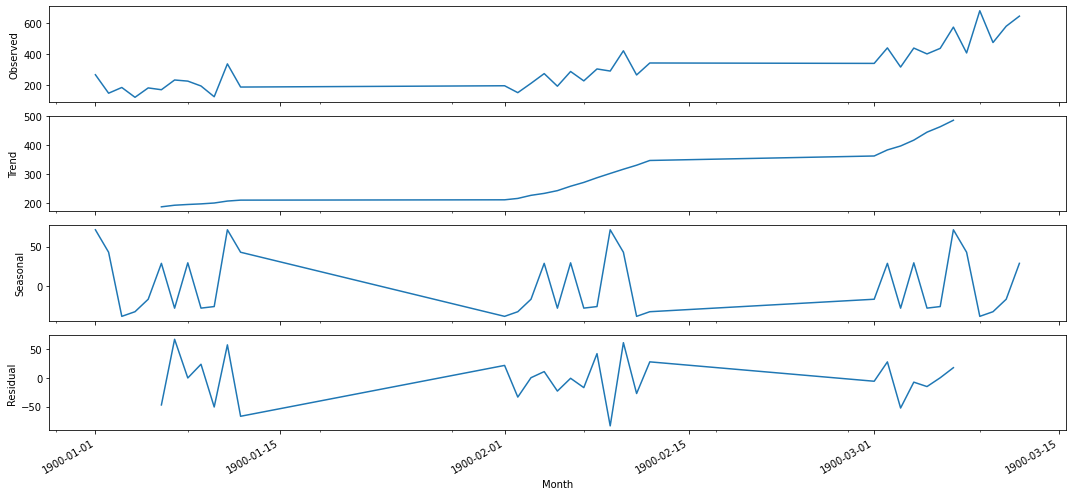

In [155]:
decompose_data = sm.tsa.seasonal_decompose(shampoo.Sales,freq=10,model="additive")
fig = decompose_data.plot()
plt.show()

### Promedio

In [156]:
print(prediccion_promedio(shampoo['Sales'], (24, 'prom')))

370.67083333333335


In [157]:
prueba["error"] = prueba["Sales"] - prediccion_promedio(shampoo['Sales'], (24, 'prom'))

C:\Users\Zephyrus\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [158]:
print("Error promedio: ", prueba.error.mean())

Error promedio:  107.87916666666665


### Sarimax

In [159]:
train, prueba = division_entreno_prueba(shampoo, 12)

<AxesSubplot:xlabel='Month'>

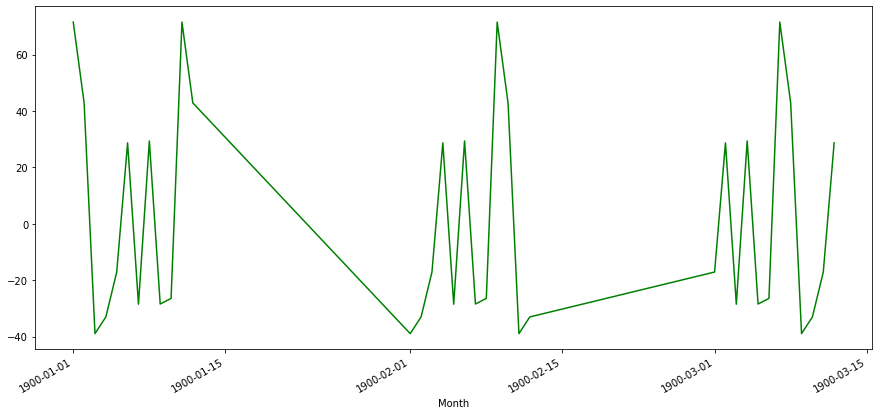

In [160]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

En este caso el valor-p es uno mayo a 0.05, esto nos indica que no es estacionaria.

In [161]:
dftest = sm.tsa.stattools.adfuller(shampoo.Sales, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  3.0601420836411775
2. P-Value :  1.0
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 25
5. Critical Values :
	 1% :  -3.7238633119999998
	 5% :  -2.98648896
	 10% :  -2.6328004


In [162]:
results = sm.tsa.statespace.SARIMAX(shampoo, order=(1,1,1), seasonal_order=(0,0,0,32), exog = shampoo, enforce_invertibility=False).fit()
results.summary()

C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 370.290
Date:                Mon, 27 Sep 2021   AIC                           -732.580
Time:                        12:40:40   BIC                           -726.358
Sample:                             0   HQIC                          -730.432
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Sales          1.0000   9.65e-21   1.04e+20      0.000       1.000       1.000
ar.L1         -0.6410   2.22e-20  -2.89e+19      0.000      -0.641      -0.641
ma.L1         -0.0948   1.32e-20  -7.19e+18      0.000      -0.095      -0.095
sigma2          1e-10   3.35e-10      0.298      0.765   -5.57e-10    7.57e-10
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                81.96
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):               4.62   Skew:                             2.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+37. Standard errors may be unstable.
"""

C:\Users\Zephyrus\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:xlabel='Month'>

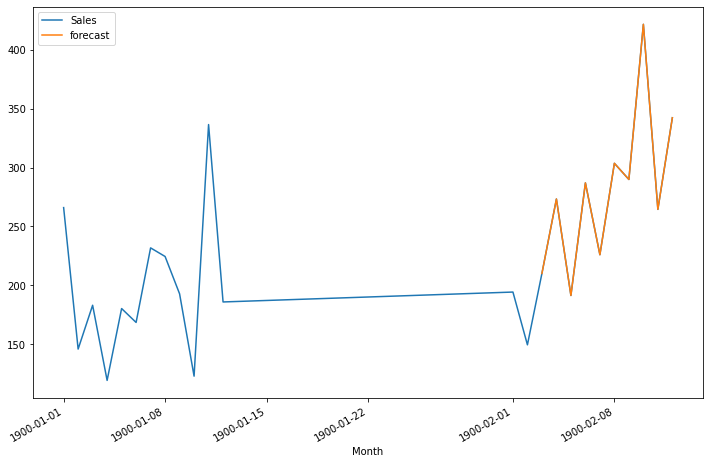

In [163]:
train['forecast']=results.predict(start=14,end=24,dynamic=True)
train[['Sales','forecast']].plot(figsize=(12,8))

In [164]:
pred = results.predict(0, 12, dinamic= True, exog = prueba)[1:]
print("MSE: ",(mean_squared_error(prueba, pred)))
print("RMSE: ", sqrt(mean_squared_error(prueba, pred)))

MSE:  97362.30833333333
RMSE:  312.02933889833713


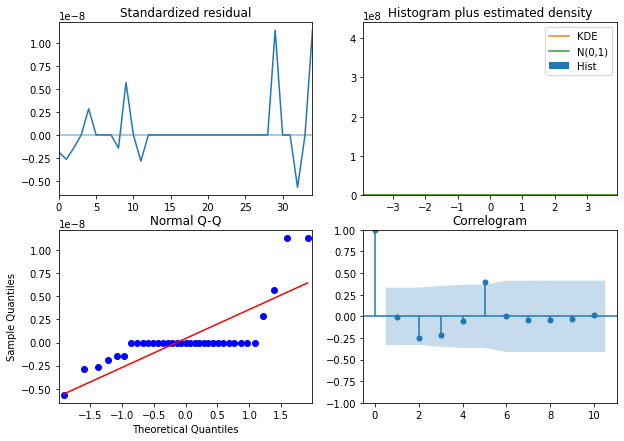

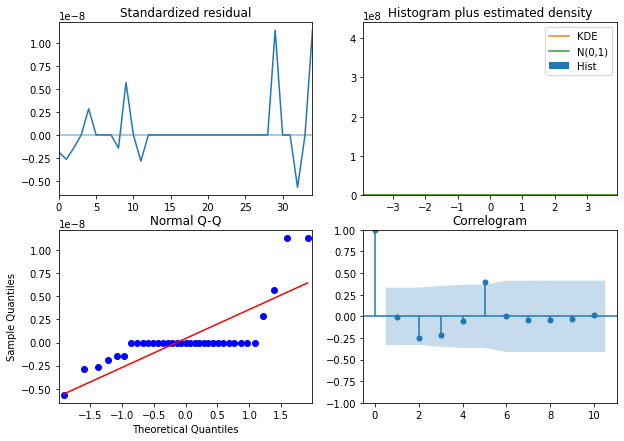

In [165]:
results.plot_diagnostics(figsize=(10, 7))

### Winter Holt

In [166]:
shampoo2 = shampoo

In [167]:
plt.rcParams['figure.figsize'] = [15, 7]

In [168]:
shampoo2.index.Sales = 'MS'
m = 12
alpha = 1/(2*m)

C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


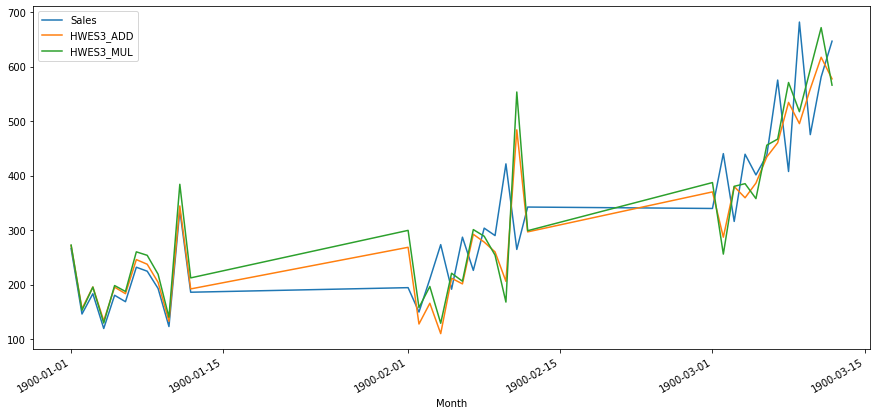

In [169]:
# Se usa triple HWES se adapta bien
shampoo2['HWES3_ADD'] = ExponentialSmoothing(shampoo2['Sales'],trend='add', seasonal='add',seasonal_periods=12).fit().fittedvalues
shampoo2['HWES3_MUL'] = ExponentialSmoothing(shampoo2['Sales'],trend='mul', seasonal='mul',seasonal_periods=12).fit().fittedvalues
shampoo2[['Sales','HWES3_ADD','HWES3_MUL']].plot();

In [170]:
train, prueba = division_entreno_prueba(shampoo, 12)

En la grafica no se observa adecuadamente pero se hicieron 12 forecast misteriosamente los etiqueta como del anio 1970.

C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

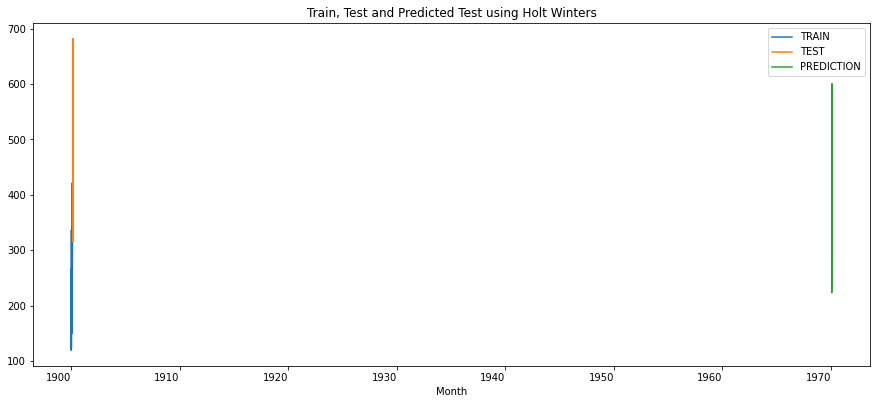

In [171]:
fitted_model = ExponentialSmoothing(train['Sales'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(12)
train['Sales'].plot(legend=True, label='TRAIN')
prueba['Sales'].plot(legend=True, label='TEST', figsize=(15,7))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [172]:
print("MSE: ", mean_squared_error(prueba.Sales,test_predictions))
print("RMSE: ",sqrt(mean_squared_error(prueba.Sales,test_predictions)))

MSE:  27541.47209501053
RMSE:  165.95623548095602


### Redes Neuronales

In [173]:
np.random.seed(7)

In [174]:
shampoo = pd.read_csv("shampoo.csv", encoding='latin1')

In [175]:
shampoo['Month'] = shampoo['Month'].apply(lambda x: datetime.datetime.strptime(x, '%m-%d') if type(x)==str else np.NaN)
shampoo.index = pd.to_datetime(shampoo['Month'])
shampoo.drop(columns='Month',inplace=True)
shampoo.head()

,Sales
Month,
1900-01-01,266.0
1900-01-02,145.9
1900-01-03,183.1
1900-01-04,119.3
1900-01-05,180.3


In [176]:
shampoo2 = shampoo

In [177]:
train, prueba = division_entreno_prueba(shampoo2, 12)

In [178]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)
prueba = sc.fit_transform(prueba)

In [179]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(prueba, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [180]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
20/20 - 1s - loss: 0.1535
Epoch 2/50
20/20 - 0s - loss: 0.1277
Epoch 3/50
20/20 - 0s - loss: 0.1056
Epoch 4/50
20/20 - 0s - loss: 0.0865
Epoch 5/50
20/20 - 0s - loss: 0.0732
Epoch 6/50
20/20 - 0s - loss: 0.0635
Epoch 7/50
20/20 - 0s - loss: 0.0584
Epoch 8/50
20/20 - 0s - loss: 0.0548
Epoch 9/50
20/20 - 0s - loss: 0.0539
Epoch 10/50
20/20 - 0s - loss: 0.0534
Epoch 11/50
20/20 - 0s - loss: 0.0527
Epoch 12/50
20/20 - 0s - loss: 0.0529
Epoch 13/50
20/20 - 0s - loss: 0.0527
Epoch 14/50
20/20 - 0s - loss: 0.0524
Epoch 15/50
20/20 - 0s - loss: 0.0528
Epoch 16/50
20/20 - 0s - loss: 0.0525
Epoch 17/50
20/20 - 0s - loss: 0.0527
Epoch 18/50
20/20 - 0s - loss: 0.0527
Epoch 19/50
20/20 - 0s - loss: 0.0525
Epoch 20/50
20/20 - 0s - loss: 0.0520
Epoch 21/50
20/20 - 0s - loss: 0.0527
Epoch 22/50
20/20 - 0s - loss: 0.0521
Epoch 23/50
20/20 - 0s - loss: 0.0521
Epoch 24/50
20/20 - 0s - loss: 0.0520
Epoch 25/50
20/20 - 0s - loss: 0.0519
Epoch 26/50
20/20 - 0s - loss: 0.0524
Epoch 27/50
20/20 - 0

In [181]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [182]:
max_value = shampoo.Sales.max()

In [183]:
testScore = sqrt(mean_squared_error(testY, testPredict[:,0])*max_value)
print("MSE: ", mean_squared_error(testY, testPredict[:,0])*max_value)
print("RMSE: ", testScore)

MSE:  46.276867589483054
RMSE:  6.802710312036156


### Prophet

In [184]:
shampoo = pd.read_csv("shampoo.csv", encoding='latin1')

In [185]:
shampoo2 = shampoo

In [186]:
import datetime
shampoo2['Month'] = shampoo2['Month'].apply(lambda x: datetime.datetime.strptime(x, '%m-%d') if type(x)==str else np.NaN)
shampoo2.columns = ['ds', 'y']
shampoo2['ds']= to_datetime(shampoo2['ds'])

In [187]:
train, prueba = division_entreno_prueba(shampoo2, 12)

In [188]:
model = fbprophet.Prophet()
# fit the model
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


La grafica muestra los meses 1 y 2, y muestra el forecast para el 3

          ds        yhat  yhat_lower  yhat_upper
0 1900-02-01  262.336680  191.493626  332.690056
1 1900-03-01  326.113923  253.402123  397.481859
2 1900-04-01  400.025649  327.738693  469.418702


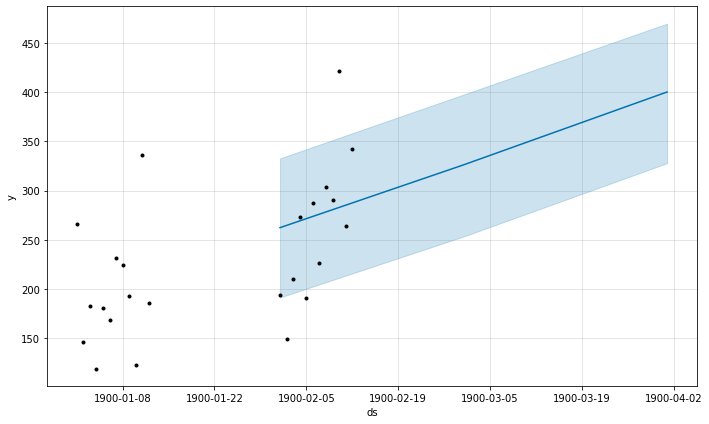

In [189]:
future = list()
for i in range(2, 5):
    date = '1900-%01d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [190]:
shampoo.index = pd.to_datetime(shampoo['ds'])
shampoo.drop(columns='ds',inplace=True)
shampoo.head()

,y
ds,
1900-01-01,266.0
1900-01-02,145.9
1900-01-03,183.1
1900-01-04,119.3
1900-01-05,180.3


In [191]:
meses = shampoo.resample('M').mean()
meses

,y
ds,
1900-01-31,196.458333
1900-02-28,262.791667
1900-03-31,478.550000


In [192]:
testScore = sqrt(mean_squared_error(meses, forecast["yhat"]))
print("MSE: ", mean_squared_error(meses, forecast["yhat"]))
print("RMSE: ", testScore)

MSE:  4838.579462293309
RMSE:  69.55989837753725


# Series de tiempo para monthly-car-sales.csv

In [193]:
cars = pd.read_csv("monthly-car-sales.csv", encoding='latin1')

In [194]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   108 non-null    object
 1   Sales   108 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [195]:
cars.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [196]:
cars.index = pd.to_datetime(cars['Month'])
cars.drop(columns='Month',inplace=True)
cars.head()

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


In [197]:
train, prueba = division_entreno_prueba(cars, 25)

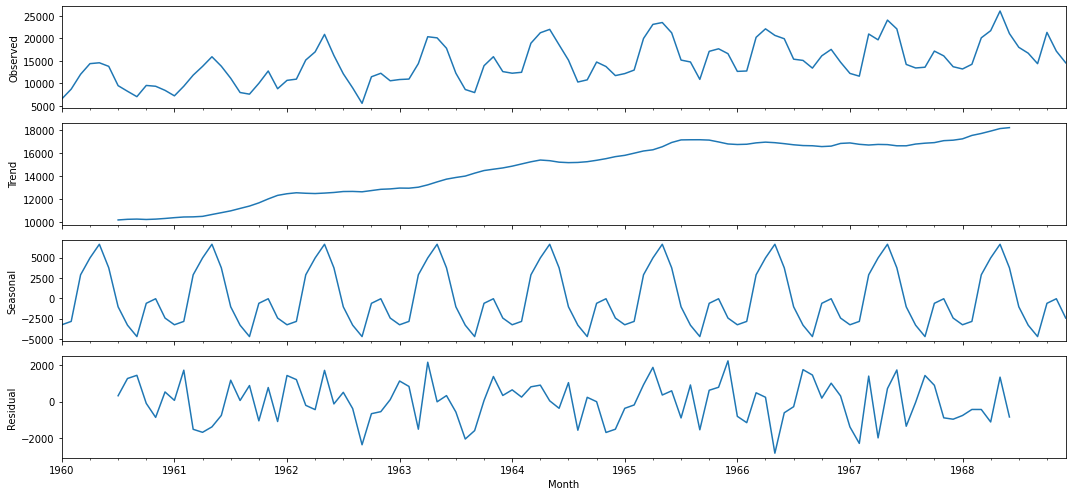

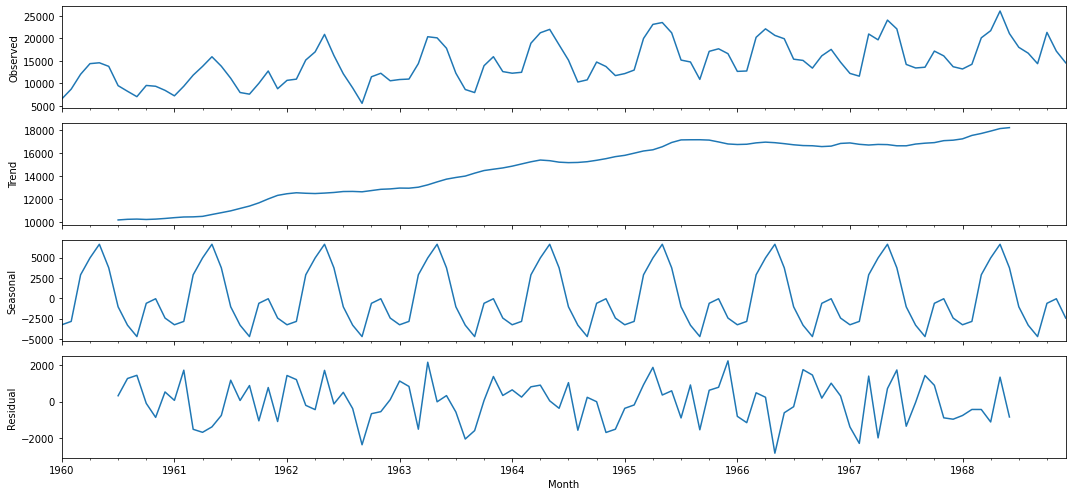

In [198]:
decompose_data = sm.tsa.seasonal_decompose(cars, model="additive")
decompose_data.plot()

### Promedio

In [199]:
print(prediccion_promedio(cars['Sales'], (85, 'prom')))

15677.070588235294


In [200]:
prueba["error"] = prueba['Sales'] - prediccion_promedio(cars['Sales'], (85, 'prom'))

C:\Users\Zephyrus\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [201]:
print("Error promedio: ", prueba.error.mean())

Error promedio:  1620.2894117647065


### Sarimax

In [202]:
cars = pd.read_csv("monthly-car-sales.csv", encoding='latin1')
cars.index = pd.to_datetime(cars['Month'])
cars.drop(columns='Month',inplace=True)
cars.head()

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


In [203]:
train, prueba = division_entreno_prueba(cars, 25)

<AxesSubplot:xlabel='Month'>

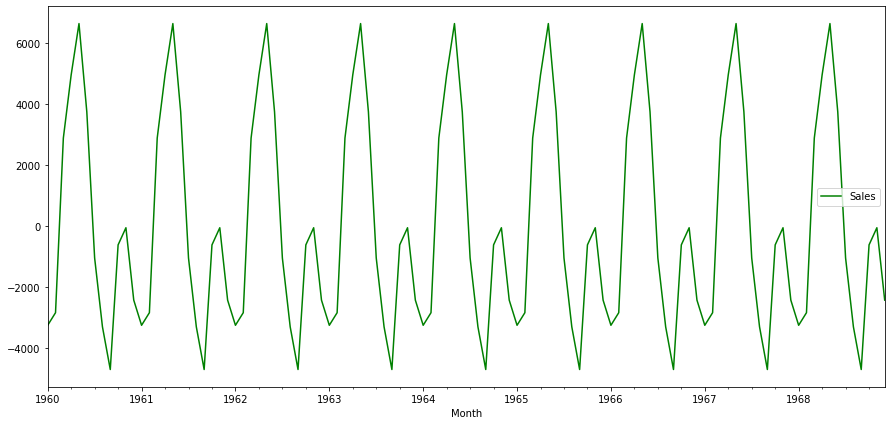

In [204]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

En este caso el valor-p es uno mayo a 0.05, esto nos indica que no es estacionaria.

In [205]:
dftest = sm.tsa.stattools.adfuller(cars.Sales, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.223812766175284
2. P-Value :  0.6632691049832868
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 95
5. Critical Values :
	 1% :  -3.5011373281819504
	 5% :  -2.8924800524857854
	 10% :  -2.5832749307479226


In [206]:
model=sm.tsa.statespace.SARIMAX(train['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [207]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   83
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -613.181
Date:                            Mon, 27 Sep 2021   AIC                           1236.363
Time:                                    12:42:12   BIC                           1247.605
Sample:                                01-01-1960   HQIC                          1240.829
                                     - 11-01-1966                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3107      0.135      2.297      0.022       0.046       0.576
ma.L1         -0.9442      0.087    -10.808      0.000      -1.115      -0.773
ar.S.L12      -0.4274      0.280     -1.529      0.126      -0.975       0.121
ma.S.L12      -0.0535      0.314     -0.170      0.865      -0.669       0.562
sigma2      2.143e+06   3.84e+05      5.581      0.000    1.39e+06     2.9e+06
===================================================================================
Ljung-Box (Q):                       69.84   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.00   Prob(JB):                         0.51
Heteroskedasticity (H):               0.96   Skew:                             0.33
Prob(H) (two-sided):                  0.93   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Zephyrus\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:xlabel='Month'>

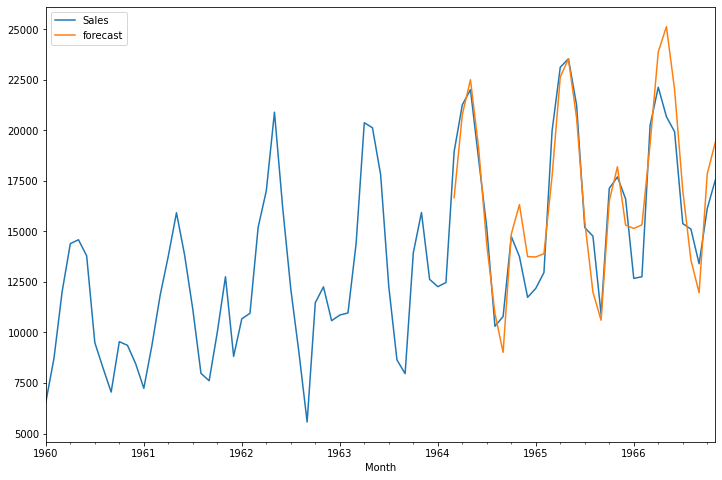

In [208]:
train['forecast']=results.predict(start=50,end=83,dynamic=True)
train[['Sales','forecast']].plot(figsize=(12,8))

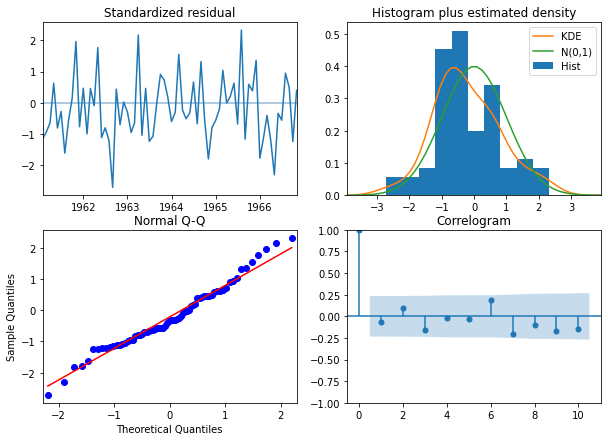

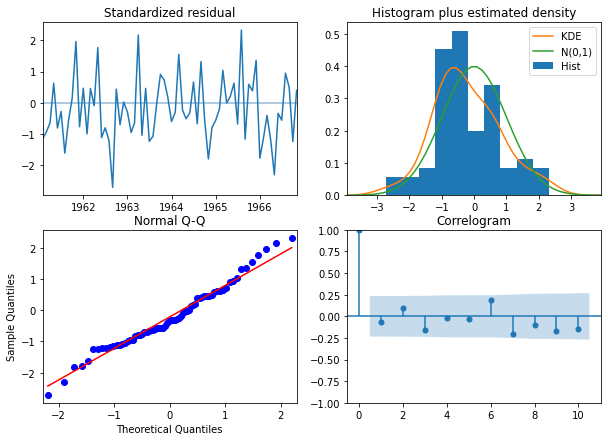

In [209]:
results.plot_diagnostics(figsize=(10, 7))

In [210]:
pred = results.predict(58, 83, dinamic= True, exog = prueba)[1:]
print("MSE: ",(mean_squared_error(prueba, pred)))
print("RMSE: ", sqrt(mean_squared_error(prueba, pred)))

MSE:  3323669.229521606
RMSE:  1823.0933134432823


C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1935: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


### Winter Holt

In [211]:
cars = pd.read_csv("monthly-car-sales.csv", encoding='latin1')
cars.index = pd.to_datetime(cars['Month'])
cars.drop(columns='Month',inplace=True)
cars.head()

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


In [212]:
cars2 = cars

In [213]:
plt.rcParams['figure.figsize'] = [15, 7]

In [214]:
cars2.index.Sales = 'MS'
m = 12
alpha = 1/(2*m)

C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


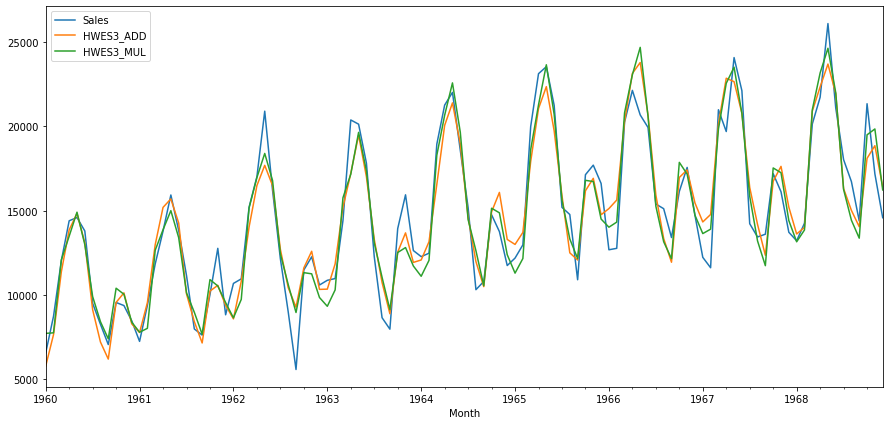

In [215]:
# Se usa triple HWES
cars2['HWES3_ADD'] = ExponentialSmoothing(cars2['Sales'],trend='add', seasonal='add',seasonal_periods=12).fit().fittedvalues
cars2['HWES3_MUL'] = ExponentialSmoothing(cars2['Sales'],trend='mul', seasonal='mul',seasonal_periods=12).fit().fittedvalues
cars2[['Sales','HWES3_ADD','HWES3_MUL']].plot();

In [216]:
train, prueba = division_entreno_prueba(cars2, 25)

C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

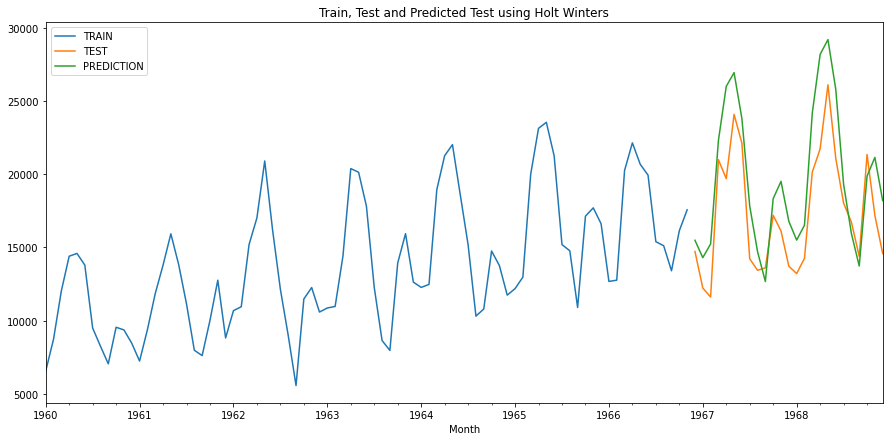

In [217]:
fitted_model = ExponentialSmoothing(train['Sales'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(25)
train['Sales'].plot(legend=True, label='TRAIN')
prueba['Sales'].plot(legend=True, label='TEST', figsize=(15,7))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [218]:
print("MSE: ", mean_squared_error(prueba.Sales,test_predictions))
print("RMSE: ",sqrt(mean_squared_error(prueba.Sales,test_predictions)))

MSE:  9663628.370479591
RMSE:  3108.637703316292


### Redes Nauronales

In [219]:
np.random.seed(7)

In [220]:
cars = pd.read_csv("monthly-car-sales.csv", encoding='latin1')
cars.index = pd.to_datetime(cars['Month'])
cars.drop(columns='Month',inplace=True)
cars.head()

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


In [221]:
train, prueba = division_entreno_prueba(cars, 25)

In [222]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)
prueba = sc.fit_transform(prueba)

In [223]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(prueba, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [224]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
79/79 - 2s - loss: 0.1102
Epoch 2/50
79/79 - 0s - loss: 0.0588
Epoch 3/50
79/79 - 0s - loss: 0.0475
Epoch 4/50
79/79 - 0s - loss: 0.0463
Epoch 5/50
79/79 - 0s - loss: 0.0460
Epoch 6/50
79/79 - 0s - loss: 0.0457
Epoch 7/50
79/79 - 0s - loss: 0.0457
Epoch 8/50
79/79 - 0s - loss: 0.0452
Epoch 9/50
79/79 - 0s - loss: 0.0449
Epoch 10/50
79/79 - 0s - loss: 0.0452
Epoch 11/50
79/79 - 0s - loss: 0.0444
Epoch 12/50
79/79 - 0s - loss: 0.0444
Epoch 13/50
79/79 - 0s - loss: 0.0442
Epoch 14/50
79/79 - 0s - loss: 0.0433
Epoch 15/50
79/79 - 0s - loss: 0.0430
Epoch 16/50
79/79 - 0s - loss: 0.0429
Epoch 17/50
79/79 - 0s - loss: 0.0426
Epoch 18/50
79/79 - 0s - loss: 0.0417
Epoch 19/50
79/79 - 0s - loss: 0.0416
Epoch 20/50
79/79 - 0s - loss: 0.0415
Epoch 21/50
79/79 - 0s - loss: 0.0407
Epoch 22/50
79/79 - 0s - loss: 0.0396
Epoch 23/50
79/79 - 0s - loss: 0.0389
Epoch 24/50
79/79 - 0s - loss: 0.0388
Epoch 25/50
79/79 - 0s - loss: 0.0383
Epoch 26/50
79/79 - 0s - loss: 0.0386
Epoch 27/50
79/79 - 0

In [225]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [226]:
max_value = cars.Sales.max()
testScore = sqrt(mean_squared_error(testY, testPredict[:,0])*max_value)
print("MSE: ", mean_squared_error(testY, testPredict[:,0])*max_value)
print("RMSE: ", testScore)

MSE:  1262.507045521261
RMSE:  35.53177515297063


### Prophet

In [227]:
from pandas import to_datetime
cars = pd.read_csv("monthly-car-sales.csv", encoding='latin1')

In [228]:
cars2 = cars

In [229]:
cars2.columns = ['ds', 'y']
cars2['ds']= to_datetime(cars2['ds'])

In [230]:
train, prueba = division_entreno_prueba(cars2, 25)

In [231]:
model = fbprophet.Prophet()
# fit the model
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [232]:
train

,ds,y
0,1960-01-01,6550
1,1960-02-01,8728
2,1960-03-01,12026
3,1960-04-01,14395
4,1960-05-01,14587
...,...,...
78,1966-07-01,15388
79,1966-08-01,15113
80,1966-09-01,13401
81,1966-10-01,16135


In [233]:
prueba

,ds,y
83,1966-12-01,14720
84,1967-01-01,12225
85,1967-02-01,11608
86,1967-03-01,20985
87,1967-04-01,19692
88,1967-05-01,24081
89,1967-06-01,22114
90,1967-07-01,14220
91,1967-08-01,13434
92,1967-09-01,13598


          ds          yhat    yhat_lower    yhat_upper
0 1967-01-01  15359.999290  13890.340527  16822.094913
1 1967-02-01  16151.661185  14676.421731  17520.471031
2 1967-03-01  19827.485042  18435.478466  21202.616430
3 1967-04-01  24243.805504  22890.404321  25636.891227
4 1967-05-01  25233.973679  23819.140110  26540.202239


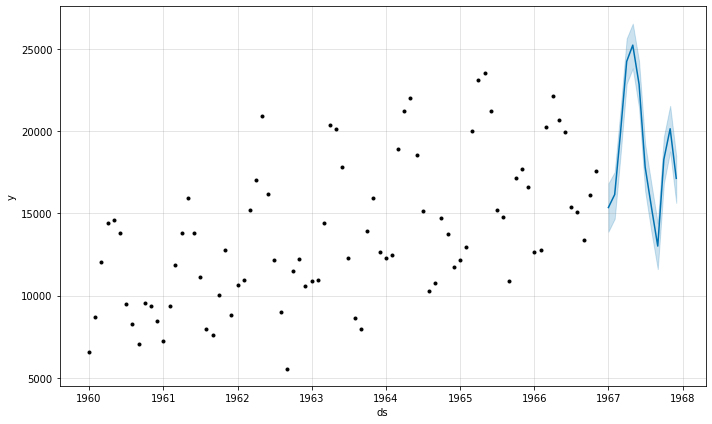

In [234]:
future = list()
for i in range(1, 13):
    date = '1967-%1d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [235]:
cars.index = pd.to_datetime(cars['ds'])
cars.drop(columns='ds',inplace=True)
cars.head()

,y
ds,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


In [236]:
to_compare = cars[-24:]
to_compare = to_compare[:-12]
to_compare

,y
ds,
1967-01-01,12225
1967-02-01,11608
1967-03-01,20985
1967-04-01,19692
1967-05-01,24081
1967-06-01,22114
1967-07-01,14220
1967-08-01,13434
1967-09-01,13598


In [237]:
testScore = sqrt(mean_squared_error(to_compare, forecast["yhat"]))
print("MSE: ", mean_squared_error(to_compare, forecast["yhat"]))
print("RMSE: ", testScore)

MSE:  8382849.213535543
RMSE:  2895.3150456445223


# Series de tiempo para monthly-mean-temp.csv

In [238]:
mmt = pd.read_csv("monthly-mean-temp.csv", encoding='latin1')

In [239]:
mmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        240 non-null    object 
 1   Temperature  240 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


In [240]:
mmt.head()

,Month,Temperature
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1


In [241]:
mmt.index = pd.to_datetime(mmt['Month'])
mmt.drop(columns='Month',inplace=True)
mmt.head()

,Temperature
Month,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


In [242]:
train, prueba = division_entreno_prueba(mmt, 70)

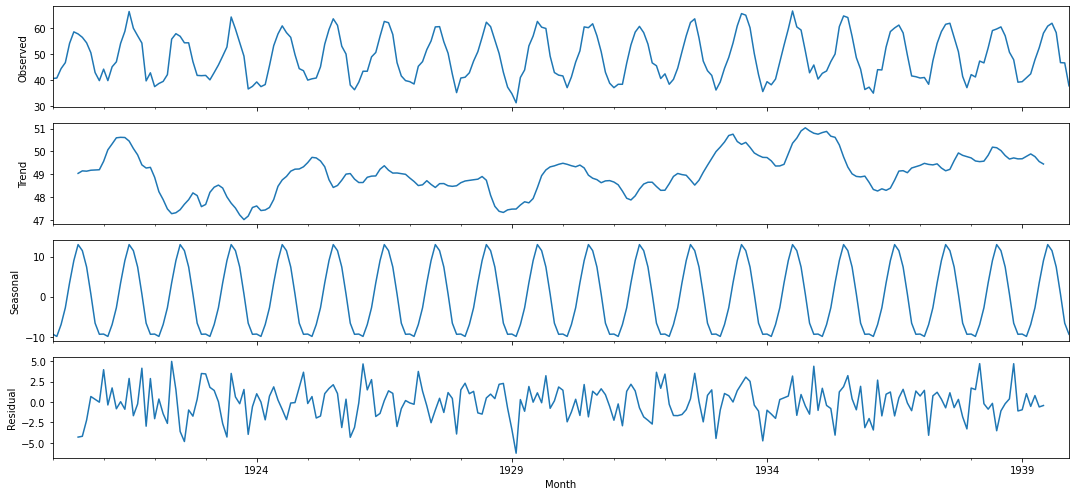

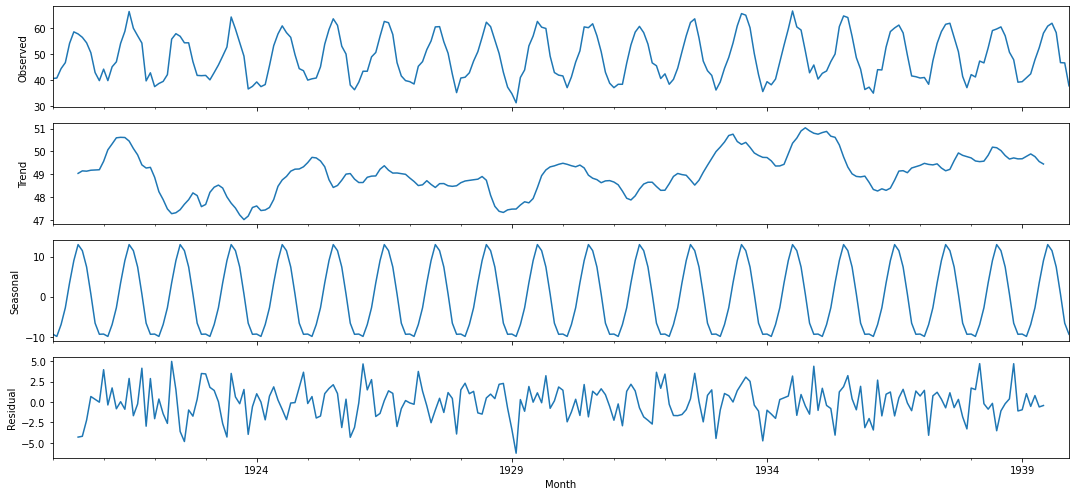

In [243]:
decompose_data = sm.tsa.seasonal_decompose(mmt, model="additive")
decompose_data.plot()

### Promedio

In [244]:
print(prediccion_promedio(mmt['Temperature'], (170, 'prom')))

49.06588235294117


In [245]:
prueba["error"] = prueba['Temperature'] - prediccion_promedio(mmt['Temperature'], (170, 'prom'))

C:\Users\Zephyrus\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [246]:
print("Error promedio: ", prueba.error.mean())

Error promedio:  0.8384033613445404


### Sarimax

In [247]:
mmt = pd.read_csv("monthly-mean-temp.csv", encoding='latin1')
mmt.index = pd.to_datetime(mmt['Month'])
mmt.drop(columns='Month',inplace=True)
mmt.head()

,Temperature
Month,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


In [248]:
train, prueba = division_entreno_prueba(mmt, 70)

<AxesSubplot:xlabel='Month'>

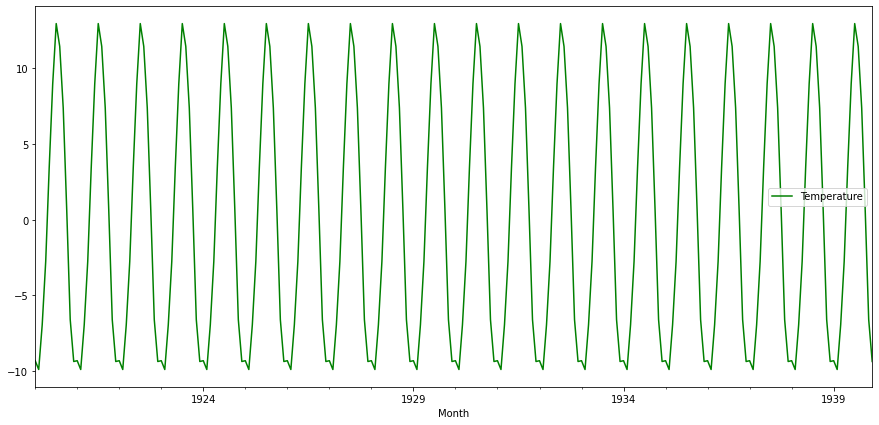

In [249]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

En este caso el valor-p es uno menor a 0.05, esto nos indica es estacionaria.

In [250]:
dftest = sm.tsa.stattools.adfuller(mmt.Temperature, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.2554924030863344
2. P-Value :  0.016989030222608715
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 225
5. Critical Values :
	 1% :  -3.4597521044060353
	 5% :  -2.874472927517147
	 10% :  -2.5736628197530864


In [251]:
model=sm.tsa.statespace.SARIMAX(train['Temperature'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [252]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        Temperature   No. Observations:                  170
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -363.718
Date:                            Mon, 27 Sep 2021   AIC                            737.435
Time:                                    12:45:45   BIC                            752.717
Sample:                                01-01-1920   HQIC                           743.642
                                     - 02-01-1934                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3330      0.090      3.717      0.000       0.157       0.509
ma.L1         -0.9736      0.043    -22.412      0.000      -1.059      -0.888
ar.S.L12      -0.3536      0.100     -3.539      0.000      -0.549      -0.158
ma.S.L12      -0.6400      0.100     -6.370      0.000      -0.837      -0.443
sigma2         5.4107      0.671      8.062      0.000       4.095       6.726
===================================================================================
Ljung-Box (Q):                       42.54   Jarque-Bera (JB):                 1.76
Prob(Q):                              0.36   Prob(JB):                         0.41
Heteroskedasticity (H):               0.91   Skew:                            -0.26
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Zephyrus\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:xlabel='Month'>

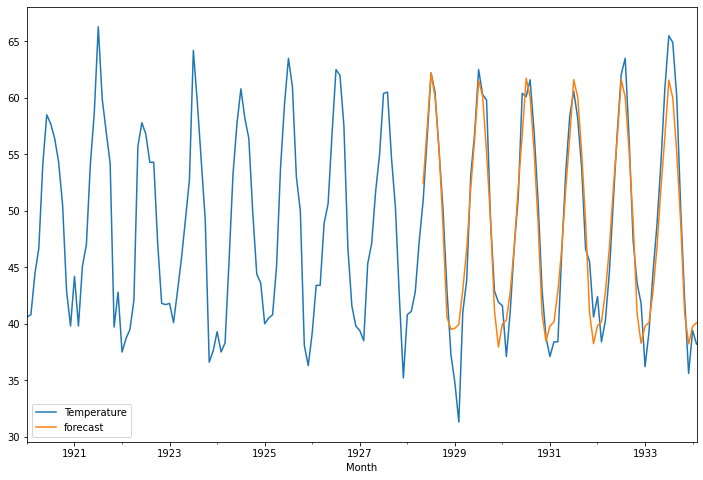

In [253]:
train['forecast']=results.predict(start=100,end=170,dynamic=True)
train[['Temperature','forecast']].plot(figsize=(12,8))

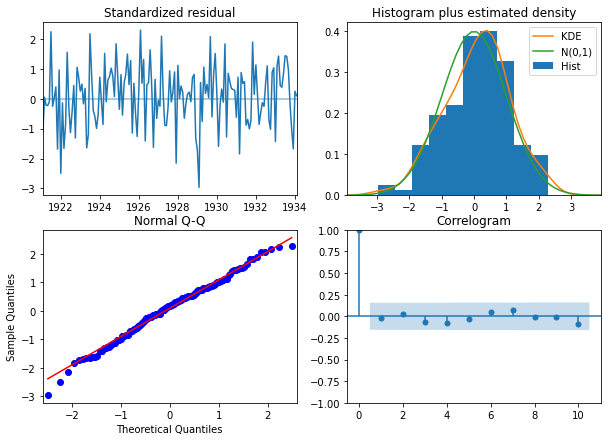

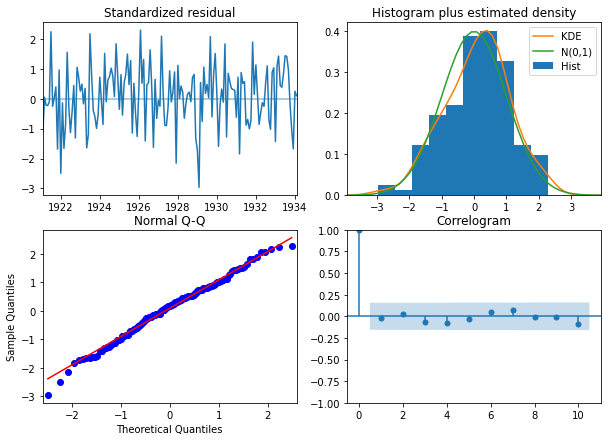

In [254]:
results.plot_diagnostics(figsize=(10, 7))

In [255]:
pred = results.predict(0, 70, dinamic= True, exog = prueba)[1:]
print("MSE: ",(mean_squared_error(prueba, pred)))
print("RMSE: ", sqrt(mean_squared_error(prueba, pred)))

MSE:  36.28088546967642
RMSE:  6.02336164194683


C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1935: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


### Winter Holt

In [256]:
mmt = pd.read_csv("monthly-mean-temp.csv", encoding='latin1')
mmt.index = pd.to_datetime(mmt['Month'])
mmt.drop(columns='Month',inplace=True)
mmt.head()

,Temperature
Month,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


In [257]:
mmt2 = mmt

In [258]:
plt.rcParams['figure.figsize'] = [15, 7]

In [259]:
mmt2.index.Temperature = 'MS'
m = 12
alpha = 1/(2*m)

C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


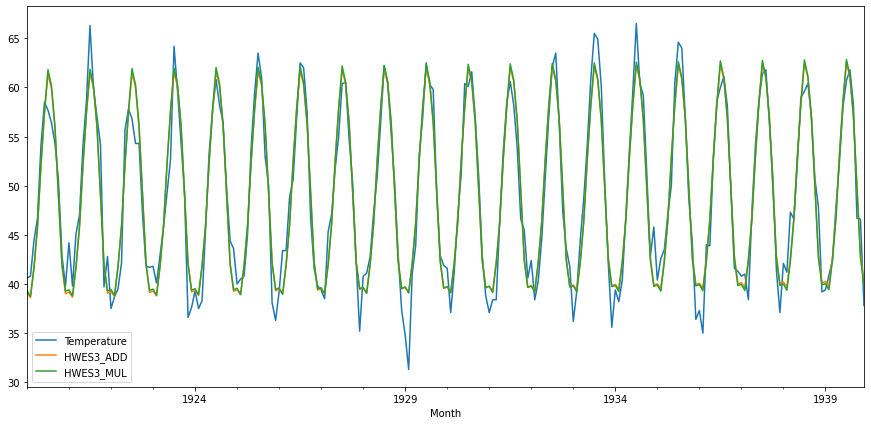

In [260]:
# Se usa triple HWES
mmt2['HWES3_ADD'] = ExponentialSmoothing(mmt2['Temperature'],trend='add', seasonal='add',seasonal_periods=12).fit().fittedvalues
mmt2['HWES3_MUL'] = ExponentialSmoothing(mmt2['Temperature'],trend='mul', seasonal='mul',seasonal_periods=12).fit().fittedvalues
mmt2[['Temperature','HWES3_ADD','HWES3_MUL']].plot();

In [261]:
train, prueba = division_entreno_prueba(mmt2, 70)

C:\Users\Zephyrus\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

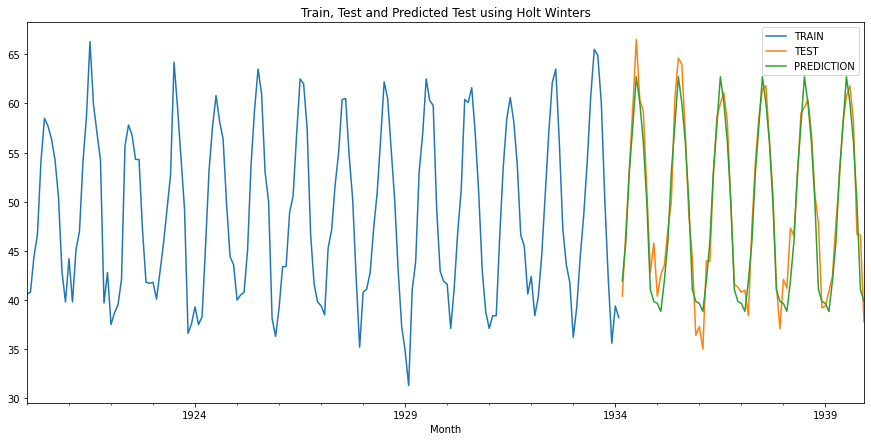

In [262]:
fitted_model = ExponentialSmoothing(train['Temperature'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(70)
train['Temperature'].plot(legend=True, label='TRAIN')
prueba['Temperature'].plot(legend=True, label='TEST', figsize=(15,7))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

In [263]:
print("MSE: ", mean_squared_error(prueba.Temperature,test_predictions))
print("RMSE: ",sqrt(mean_squared_error(prueba.Temperature,test_predictions)))

MSE:  5.643743414288412
RMSE:  2.375656417558821


### Redes Nauronales

In [264]:
np.random.seed(7)

In [265]:
mmt = pd.read_csv("monthly-mean-temp.csv", encoding='latin1')
mmt.index = pd.to_datetime(mmt['Month'])
mmt.drop(columns='Month',inplace=True)
mmt.head()

,Temperature
Month,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


In [266]:
train, prueba = division_entreno_prueba(mmt, 70)

In [267]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)
prueba = sc.fit_transform(prueba)

In [268]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(prueba, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [269]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
166/166 - 1s - loss: 0.0877
Epoch 2/50
166/166 - 0s - loss: 0.0459
Epoch 3/50
166/166 - 0s - loss: 0.0446
Epoch 4/50
166/166 - 0s - loss: 0.0444
Epoch 5/50
166/166 - 0s - loss: 0.0433
Epoch 6/50
166/166 - 0s - loss: 0.0417
Epoch 7/50
166/166 - 0s - loss: 0.0420
Epoch 8/50
166/166 - 0s - loss: 0.0406
Epoch 9/50
166/166 - 0s - loss: 0.0400
Epoch 10/50
166/166 - 0s - loss: 0.0389
Epoch 11/50
166/166 - 0s - loss: 0.0377
Epoch 12/50
166/166 - 0s - loss: 0.0368
Epoch 13/50
166/166 - 0s - loss: 0.0354
Epoch 14/50
166/166 - 0s - loss: 0.0342
Epoch 15/50
166/166 - 0s - loss: 0.0328
Epoch 16/50
166/166 - 0s - loss: 0.0319
Epoch 17/50
166/166 - 0s - loss: 0.0292
Epoch 18/50
166/166 - 0s - loss: 0.0274
Epoch 19/50
166/166 - 0s - loss: 0.0255
Epoch 20/50
166/166 - 0s - loss: 0.0233
Epoch 21/50
166/166 - 0s - loss: 0.0207
Epoch 22/50
166/166 - 0s - loss: 0.0187
Epoch 23/50
166/166 - 0s - loss: 0.0165
Epoch 24/50
166/166 - 0s - loss: 0.0145
Epoch 25/50
166/166 - 0s - loss: 0.0130
Epoch 26/

In [270]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [271]:
max_value = mmt.Temperature.max()
testScore = sqrt(mean_squared_error(testY, testPredict[:,0])*max_value)
print("MSE: ", mean_squared_error(testY, testPredict[:,0])*max_value)
print("RMSE: ", testScore)

MSE:  0.6814390998286399
RMSE:  0.8254932463858441


### Prophet

In [288]:
from pandas import to_datetime
mmt = pd.read_csv("monthly-mean-temp.csv", encoding='latin1')

In [289]:
mmt2 = mmt

In [290]:
mmt2.columns = ['ds', 'y']
mmt2['ds']= to_datetime(mmt2['ds'])

In [291]:
train, prueba = division_entreno_prueba(mmt2, 70)

In [292]:
model = fbprophet.Prophet()
# fit the model
model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [293]:
train

,ds,y
0,1920-01-01,40.6
1,1920-02-01,40.8
2,1920-03-01,44.4
3,1920-04-01,46.7
4,1920-05-01,54.1
...,...,...
165,1933-10-01,50.2
166,1933-11-01,42.1
167,1933-12-01,35.6
168,1934-01-01,39.4


In [294]:
prueba

,ds,y
170,1934-03-01,40.4
171,1934-04-01,46.9
172,1934-05-01,53.4
173,1934-06-01,59.6
174,1934-07-01,66.5
...,...,...
235,1939-08-01,61.8
236,1939-09-01,58.2
237,1939-10-01,46.7
238,1939-11-01,46.6


          ds       yhat  yhat_lower  yhat_upper
0 1939-01-01  41.043617   38.327508   43.898024
1 1939-02-01  40.178723   37.140690   42.818077
2 1939-03-01  42.873673   40.045209   45.687710
3 1939-04-01  47.318448   44.476314   50.237956
4 1939-05-01  53.351888   50.355355   56.182606


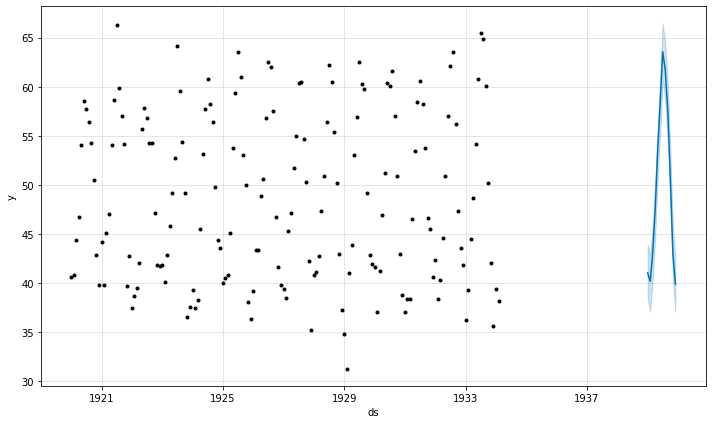

In [295]:
future = list()
for i in range(1, 13):
    date = '1939-%1d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

In [296]:
mmt.index = pd.to_datetime(mmt['ds'])
mmt.drop(columns='ds',inplace=True)
mmt.head()

,y
ds,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


In [297]:
to_compare = mmt[-12:]
to_compare

,y
ds,
1939-01-01,39.4
1939-02-01,40.9
1939-03-01,42.4
1939-04-01,47.8
1939-05-01,52.4
1939-06-01,58.0
1939-07-01,60.7
1939-08-01,61.8
1939-09-01,58.2


In [298]:
testScore = sqrt(mean_squared_error(to_compare, forecast["yhat"]))
print("MSE: ", mean_squared_error(to_compare, forecast["yhat"]))
print("RMSE: ", testScore)

MSE:  3.894924138868595
RMSE:  1.9735562162929625


### ¿Qué métodos logran captar mejor las tendencias y las variaciones estacionales?
Al observar las descompocisiones de los data sets y las graficas generadas para cada metodo, se evidencia que los metodos Winter-Holt, SARIMA y Prophet logran captar y predecir bien las tendencias y variaciones estacionales de la data. Sin embargo, al ver los RMSE las predicciones de las redes neuronales son las mas acertadas.

### Generen una tabla comparativa que muestre los RMSE más bajos para cada método con cada conjunto de datos

In [300]:
rmse = pd.read_csv("tablaRMSE.csv", encoding='latin1')
rmse

,Unnamed: 0,Ninguna tendencia,Tendencia,Estacionalidad,Tendencia y Estacionalidad
0,Metodo/Datos,Nacimiento,Shampoo,Temperatura,Carros
1,Promedio,1.51,107.88,0.84,1620.29
2,SARIMA,9.85,312.03,6.02,1823.09
3,Holt-Winter,7.79,165.96,2.37,3108.64
4,Red Neuronal,1.59 (Ganador),6.80 (Ganador),0.83 (Ganador),35.53 (Ganador)
5,Prophet,3.65,69.55,1.97,2895.31


### Ahora apliquen el FB Prophet con cada uno de los conjuntos de datos. Compare los resultados con los de los métodos anteriores.  ¿Hay algún ganador claro, entre todos los métodos?
Para los datasets de nacimiento, shampoo, temperatura y carros, FB Prophet obtuvo RMSE de 3.65, 69.56, 1.97 y 2895.32 respectivamente. A pesar de no ser el ganador en cada set, Prophet demuestra obtener un RMSE bajo consistentemente y no muestra una diferencia significativa del ganador. Es interesante ver como la Red Neuronal presento los mejores resultados en cada set, teniendo un RMSE significativamente bajo comparado con sus competidores.

### Escriban sus conclusiones sobre lo aprendido en este módulo sobre series de tiempo.  ¿Cuál es el mejor procedimiento para resolver un problema de predicción de series de tiempo?
- Hay una gran cantidad de metodos para series de tiempo y algunos demuestran ser mas eficientes que otros dependiendo del problema a resolver
- La eleccion de los hiper-parametros y valores que se les dan a los metodos pueden tener un gran impacto en el analisis, por lo que se deben trabajar con cuidado
- Un buen procedimiento para resolver un problema de prediccion de serie de tiempo debe incluir el uso de varios metodos como los que utilizamos aqui. De esta manera se puede hacer una comparacion entre los resultados que luego se utiliza para hacer un analisis mas profundo del problema a solucionar
- En nuestro estudio las redes neuronales presentan ser la mejor opcion para trabajar series de tiempo, sin embargo, siempre es prudente trabajar varios metodos para compararlos entre si.

## Bibliografia

https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/  
https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873  
https://www.analyticsvidhya.com/blog/2021/06/time-series-analysis-recurrence-neural-network-in-python/  
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/